## import & 데이터 로드

In [5]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
df = pd.read_csv('ML_olist.csv')
print(f"데이터 크기: {df.shape}")
print(f"\n컬럼 목록: {df.columns.tolist()}")
df.head()


데이터 크기: (85804, 14)

컬럼 목록: ['order_id', 'order_approved_at', 'order_delivered_carrier_date', 'seller_id', 'shipping_limit_date', 'product_category_name_english', 'review_score', 'review_comment_message', 'payment_types', 'has_text_review', 'seller_processing_days', 'is_logistics_fault', 'seller_delay_days', 'processing_days_diff']


,order_id,order_approved_at,order_delivered_carrier_date,seller_id,shipping_limit_date,product_category_name_english,review_score,review_comment_message,payment_types,has_text_review,seller_processing_days,is_logistics_fault,seller_delay_days,processing_days_diff
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 11:07:15,2017-10-04 19:55:00,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,housewares,4.0,"Não testei o produto ainda, mas ele veio corre...","credit_card,voucher",True,2.37,False,-1.63,0.34
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 03:24:27,2018-07-26 14:31:00,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,perfumery,4.0,Muito bom o produto.,boleto,True,0.46,False,-3.54,2.02
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:55:23,2018-08-08 13:50:00,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,auto,5.0,NaN,credit_card,False,0.20,False,-4.80,2.17
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:45:59,2017-11-22 13:39:59,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,pet_shop,5.0,O produto foi exatamente o que eu esperava e e...,credit_card,True,3.75,False,-1.25,-0.88
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 22:20:29,2018-02-14 19:46:34,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,stationery,5.0,NaN,credit_card,False,0.89,False,-5.03,1.85


## 판매자별 데이터 집계 (유석님 코드)

In [6]:
# 판매자별 집계
seller_agg = df.groupby('seller_id').agg({
    'order_id': 'count',  # 총 주문 수
    'review_score': ['mean', 'std'],  # 리뷰 평균, 표준편차
    'seller_processing_days': 'mean'  # 처리시간 통계
}).reset_index()

# 컬럼명 정리
seller_agg.columns = ['seller_id', 'total_orders', 'avg_review_score', 'std_review_score',
                      'avg_processing_days']

# 1~3점(low) 리뷰 비율 계산
low_review = df[df['review_score'].isin([1, 2, 3])].groupby('seller_id').size()
seller_agg['low_review_count'] = seller_agg['seller_id'].map(low_review).fillna(0).astype(int)
seller_agg['low_review_ratio'] = seller_agg['low_review_count'] / seller_agg['total_orders']

print(f"총 판매자 수: {len(seller_agg)}")
seller_agg.head().T

총 판매자 수: 2817


,0,1,2,3,4
seller_id,0015a82c2db000af6aaaf3ae2ecb0532,001cca7ae9ae17fb1caed9dfb1094831,002100f778ceb8431b7a1020ff7ab48f,003554e2dce176b5555353e4f3555ac8,004c9cd9d87a3c30c522c48c4fc07416
total_orders,1,183,48,1,133
avg_review_score,5.0,4.054645,4.25,5.0,4.300752
std_review_score,NaN,1.369715,1.139242,NaN,1.154602
avg_processing_days,5.08,2.206612,3.669375,0.52,1.442632
low_review_count,0,42,11,0,26
low_review_ratio,0.0,0.229508,0.229167,0.0,0.195489


In [7]:
# 분포 확인 

In [8]:
# 주요 변수 분포 확인
target_cols = ['avg_processing_days', 'low_review_ratio']

def get_distribution_stats(series, name):
    """분포 통계 계산"""
    stats_dict = {
        'Variable': name,
        'Count': series.count(),
        'Mean': series.mean(),
        'Std': series.std(),
        'Median': series.median(),
        '25%': series.quantile(0.25),
        '50%': series.quantile(0.50),
        '75%': series.quantile(0.75),
        '90%': series.quantile(0.90)
    }
    return stats_dict

# 판매자 레벨 분포 통계
print("=" * 70)
print("판매자 레벨 주요 변수 분포 (seller_agg)")
print("=" * 70)

stats_list = []
for col in target_cols:
    stats_list.append(get_distribution_stats(seller_agg[col].dropna(), col))

stats_df = pd.DataFrame(stats_list)
stats_df = stats_df.set_index('Variable')
print(stats_df.round(4).to_string())

# 주문 레벨 분포
print("\n" + "=" * 70)
print("주문 레벨 분포 (df - seller_processing_days)")
print("=" * 70)
order_stats = get_distribution_stats(df['seller_processing_days'].dropna(), 'seller_processing_days')
print(pd.DataFrame([order_stats]).set_index('Variable').round(4).to_string())

판매자 레벨 주요 변수 분포 (seller_agg)
                     Count    Mean     Std  Median   25%     50%     75%     90%
Variable                                                                        
avg_processing_days   2817  3.0820  3.4230  2.1500  1.35  2.1500  3.5725  5.8539
low_review_ratio      2817  0.1899  0.2423  0.1285  0.00  0.1285  0.2619  0.5000

주문 레벨 분포 (df - seller_processing_days)
                        Count    Mean     Std  Median  25%   50%   75%   90%
Variable                                                                    
seller_processing_days  85804  2.8352  3.3526    1.85  0.9  1.85  3.62  6.02


In [9]:
## 시각화

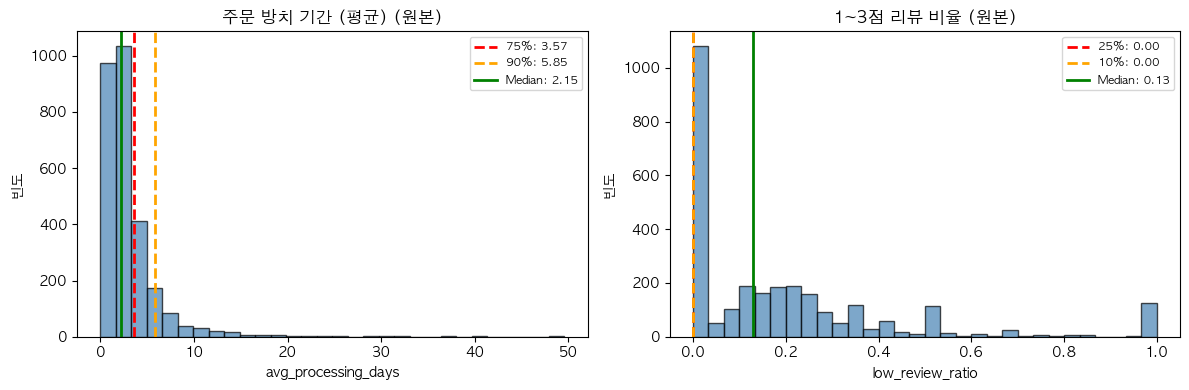

In [10]:
# 분포 시각화 (원본)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

titles = ['주문 방치 기간 (평균)', '1~3점 리뷰 비율']

for ax, col, title in zip(axes, target_cols, titles):
    data = seller_agg[col].dropna()
    
    ax.hist(data, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    
    # 1~3점 비율은 25%, 10% 기준 적용
    if col == 'low_review_ratio':
        ax.axvline(x=data.quantile(0.25), color='red', linestyle='--', linewidth=2, label=f'25%: {data.quantile(0.25):.2f}')
        ax.axvline(x=data.quantile(0.10), color='orange', linestyle='--', linewidth=2, label=f'10%: {data.quantile(0.10):.2f}')
    else:
        ax.axvline(x=data.quantile(0.75), color='red', linestyle='--', linewidth=2, label=f'75%: {data.quantile(0.75):.2f}')
        ax.axvline(x=data.quantile(0.90), color='orange', linestyle='--', linewidth=2, label=f'90%: {data.quantile(0.90):.2f}')
    
    ax.axvline(x=data.median(), color='green', linestyle='-', linewidth=2, label=f'Median: {data.median():.2f}')
    ax.set_xlabel(col)
    ax.set_ylabel('빈도')
    ax.set_title(f'{title} (원본)')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

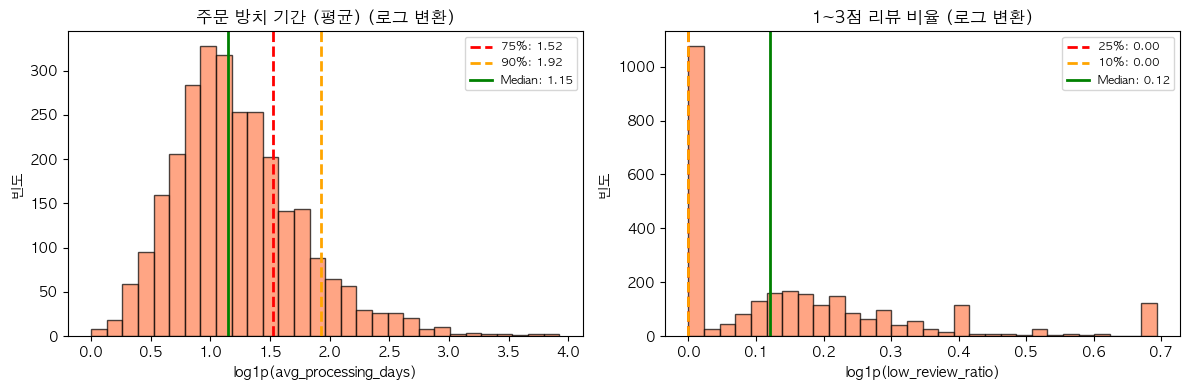

In [11]:
# 분포 시각화 (로그 변환)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

titles = ['주문 방치 기간 (평균)', '1~3점 리뷰 비율']

for ax, col, title in zip(axes, target_cols, titles):
    data = seller_agg[col].dropna()
    # log1p: log(1+x) - 0값 처리 가능
    data_log = np.log1p(data)
    
    ax.hist(data_log, bins=30, edgecolor='black', alpha=0.7, color='coral')
    
    # 로그 변환된 분위수 표시
    if col == 'low_review_ratio':
        ax.axvline(x=np.log1p(data.quantile(0.25)), color='red', linestyle='--', linewidth=2, 
                   label=f'25%: {np.log1p(data.quantile(0.25)):.2f}')
        ax.axvline(x=np.log1p(data.quantile(0.10)), color='orange', linestyle='--', linewidth=2, 
                   label=f'10%: {np.log1p(data.quantile(0.10)):.2f}')
    else:
        ax.axvline(x=np.log1p(data.quantile(0.75)), color='red', linestyle='--', linewidth=2, 
                   label=f'75%: {np.log1p(data.quantile(0.75)):.2f}')
        ax.axvline(x=np.log1p(data.quantile(0.90)), color='orange', linestyle='--', linewidth=2, 
                   label=f'90%: {np.log1p(data.quantile(0.90)):.2f}')
    
    ax.axvline(x=data_log.median(), color='green', linestyle='-', linewidth=2, 
               label=f'Median: {data_log.median():.2f}')
    ax.set_xlabel(f'log1p({col})')
    ax.set_ylabel('빈도')
    ax.set_title(f'{title} (로그 변환)')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

## 판매건수 기준 판매자 분류 (유석님 코드)

In [12]:
# 판매건수 분포 확인
print("=== 판매건수 (total_orders) 분포 ===")
print(seller_agg['total_orders'].describe())

# 판매건수 분위수
q50_orders = seller_agg['total_orders'].quantile(0.50)
q75_orders = seller_agg['total_orders'].quantile(0.75)

print(f"\n판매건수 50%: {q50_orders}")
print(f"판매건수 75%: {q75_orders}")

# 판매자 그룹 분류
seller_agg['seller_group'] = pd.cut(
    seller_agg['total_orders'],
    bins=[-np.inf, q50_orders, q75_orders, np.inf],
    labels=['하위(~50%)', '중위(50-75%)', '상위(75%~)']
)

=== 판매건수 (total_orders) 분포 ===
count    2817.000000
mean       30.459354
std        95.413900
min         1.000000
25%         2.000000
50%         7.000000
75%        21.000000
max      1620.000000
Name: total_orders, dtype: float64

판매건수 50%: 7.0
판매건수 75%: 21.0


In [13]:
upper_group = seller_agg[seller_agg['seller_group'] == '상위(75%~)']
middle_group = seller_agg[seller_agg['seller_group'] == '중위(50-75%)']

# 기준 변수들
criterion_cols = ['avg_processing_days', 'low_review_ratio']

print("=" * 70)
print("그룹별 기준값 (엄격/유한)")
print("=" * 70)

criteria_summary = []

for col in criterion_cols:
    # low_review_ratio는 반대로 25%, 10% 기준 적용
    if col == 'low_review_ratio':
        upper_strict = upper_group[col].quantile(0.25)  # 엄격: 25%
        upper_lenient = upper_group[col].quantile(0.10)  # 유한: 10%
        middle_strict = middle_group[col].quantile(0.25)
        middle_lenient = middle_group[col].quantile(0.10)
        criteria_summary.append({
            'Variable': col,
            '상위그룹_25%': upper_strict,
            '상위그룹_10%': upper_lenient,
            '중위그룹_25%': middle_strict,
            '중위그룹_10%': middle_lenient
        })
    else:
        upper_75 = upper_group[col].quantile(0.75)
        upper_90 = upper_group[col].quantile(0.90)
        middle_75 = middle_group[col].quantile(0.75)
        middle_90 = middle_group[col].quantile(0.90)
        criteria_summary.append({
            'Variable': col,
            '상위그룹_75%': upper_75,
            '상위그룹_90%': upper_90,
            '중위그룹_75%': middle_75,
            '중위그룹_90%': middle_90
        })

criteria_df = pd.DataFrame(criteria_summary)
print(criteria_df.round(4).to_string(index=False))

그룹별 기준값 (엄격/유한)
           Variable  상위그룹_75%  상위그룹_90%  중위그룹_75%  중위그룹_90%  상위그룹_25%  상위그룹_10%  중위그룹_25%  중위그룹_10%
avg_processing_days    3.3462    5.0065    3.4524    5.3552       NaN       NaN       NaN       NaN
   low_review_ratio       NaN       NaN       NaN       NaN    0.1293    0.0833    0.0817       0.0


## 주문 방치 분석 (approve - carrier) (유석님 코드)

In [14]:
# 카테고리별 주문 방치 기간 분석
category_processing = df.groupby('product_category_name_english')['seller_processing_days'].agg(['mean', 'median', 'std', 'count'])
category_processing = category_processing.sort_values('mean', ascending=False)

print("=== 카테고리별 주문 방치 기간 (상위 20개) ===")
print(category_processing.head(20).round(2).to_string())

=== 카테고리별 주문 방치 기간 (상위 20개) ===
                                mean  median   std  count
product_category_name_english                            
office_furniture               10.12    9.66  5.83   1276
fashion_shoes                   5.64    4.53  4.89    204
fashion_male_clothing           4.51    2.94  4.97    104
home_appliances_2               4.51    3.53  4.65    166
home_construction               4.23    2.92  3.75    458
fashio_female_clothing          4.05    2.73  3.54     44
fashion_underwear_beach         3.78    2.15  4.44    100
furniture_bedroom               3.77    2.95  3.41     89
music                           3.57    1.99  5.60     29
furniture_living_room           3.55    2.32  3.64    392
air_conditioning                3.52    2.04  4.44    219
consoles_games                  3.51    2.12  4.71    829
art                             3.47    2.70  2.86    158
construction_tools_safety       3.37    1.81  4.67    139
diapers_and_hygiene             3.31    

In [15]:
## 시각화 

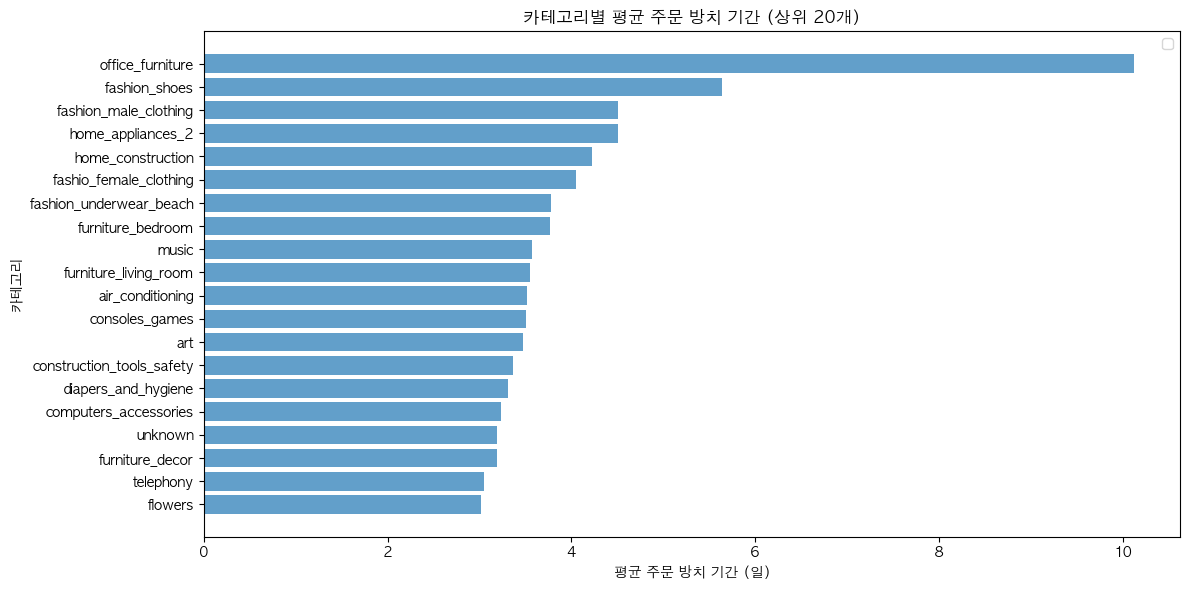

In [16]:
# 상위 20개 카테고리 시각화
top_categories = category_processing.head(20)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(top_categories.index, top_categories['mean']
               , capsize=3, alpha=0.7)
ax.set_xlabel('평균 주문 방치 기간 (일)')
ax.set_ylabel('카테고리')
ax.set_title('카테고리별 평균 주문 방치 기간 (상위 20개)')
ax.legend()
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [17]:
# 카테고리별 ANOVA 검정
from scipy.stats import f_oneway

# 주요 카테고리 (건수 100건 이상)
major_categories = category_processing[category_processing['count'] >= 100].index.tolist()
category_groups = [df[df['product_category_name_english'] == cat]['seller_processing_days'].dropna() 
                   for cat in major_categories[:10]]

f_stat, p_value = f_oneway(*category_groups)
print(f"\n=== ANOVA 검정 (상위 10개 주요 카테고리) ===")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"결론: {'카테고리별 유의한 차이 있음' if p_value < 0.05 else '카테고리별 유의한 차이 없음'}")


=== ANOVA 검정 (상위 10개 주요 카테고리) ===
F-statistic: 160.5557
P-value: 3.8134e-259
결론: 카테고리별 유의한 차이 있음


In [18]:
# 카테고리별로 처리 속도에 명확한 차이가 존재

In [19]:
# 결제수단별 주문 방치 기간 분석
# payment_types 컬럼에서 주요 결제수단 추출
df['primary_payment'] = df['payment_types'].apply(lambda x: x.split(',')[0] if pd.notna(x) else 'unknown')

payment_processing = df.groupby('primary_payment')['seller_processing_days'].agg(['mean', 'median', 'std', 'count'])
payment_processing = payment_processing.sort_values('count', ascending=False)

print("=== 결제수단별 주문 방치 기간 ===")
print(payment_processing.round(2).to_string())

=== 결제수단별 주문 방치 기간 ===
                 mean  median   std  count
primary_payment                           
credit_card      2.82    1.90  3.25  63277
boleto           2.90    1.66  3.72  19274
voucher          2.77    1.94  2.92   1986
debit_card       2.74    1.69  3.22   1267


In [20]:
## 시각화 

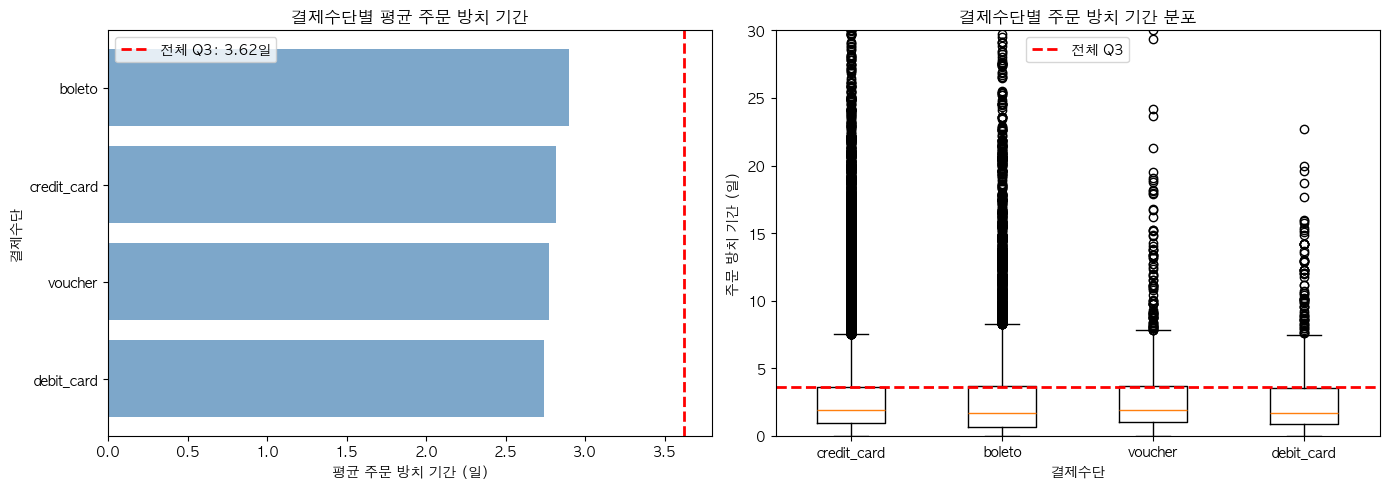

In [21]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 평균 비교
payment_sorted = payment_processing.sort_values('mean', ascending=True)
axes[0].barh(payment_sorted.index, payment_sorted['mean'], alpha=0.7, color='steelblue')
axes[0].axvline(x=df['seller_processing_days'].quantile(0.75), color='red', 
                linestyle='--', linewidth=2, label=f'전체 Q3: {df["seller_processing_days"].quantile(0.75):.2f}일')
axes[0].set_xlabel('평균 주문 방치 기간 (일)')
axes[0].set_ylabel('결제수단')
axes[0].set_title('결제수단별 평균 주문 방치 기간')
axes[0].legend()

payment_data = [df[df['primary_payment'] == p]['seller_processing_days'].dropna() 
                for p in payment_processing.index]
axes[1].boxplot(payment_data, labels=payment_processing.index, vert=True)
axes[1].axhline(y=df['seller_processing_days'].quantile(0.75), color='red', 
                linestyle='--', linewidth=2, label=f'전체 Q3')
axes[1].set_xlabel('결제수단')
axes[1].set_ylabel('주문 방치 기간 (일)')
axes[1].set_title('결제수단별 주문 방치 기간 분포')
axes[1].set_ylim(0, 30)
axes[1].legend()

plt.tight_layout()
plt.show()

In [22]:
# 결제수단별 ANOVA 검정
payment_groups = [df[df['primary_payment'] == p]['seller_processing_days'].dropna() 
                  for p in payment_processing.index if payment_processing.loc[p, 'count'] >= 100]

f_stat_pay, p_value_pay = f_oneway(*payment_groups)
print(f"\n=== ANOVA 검정 (결제수단) ===")
print(f"F-statistic: {f_stat_pay:.4f}")
print(f"P-value: {p_value_pay:.4e}")
print(f"결론: {'결제수단별 유의한 차이 있음' if p_value_pay < 0.05 else '결제수단별 유의한 차이 없음'}")


=== ANOVA 검정 (결제수단) ===
F-statistic: 3.4069
P-value: 1.6785e-02
결론: 결제수단별 유의한 차이 있음


In [23]:
# 결제 수단 간에 통계적인 차이는 존재하나, 실질적인 배송 지연의 핵심 원인으로 보기는 어렵다.

## 그룹별 유의판매자 기준 (유석님 코드)

In [24]:
# 그룹별 기준값 정의
# 상위 그룹: 엄격한 기준 (75% 수준, 단 low_ratio는 25%)
upper_processing_threshold = upper_group['avg_processing_days'].quantile(0.75)
upper_review_threshold = upper_group['avg_review_score'].quantile(0.25)  # 낮을수록 유의
upper_low_ratio_threshold = upper_group['low_review_ratio'].quantile(0.25)  # 25%로 변경 (반대)

# 중위 그룹: 유한 기준 (90% 수준, 단 low_ratio는 10%)
middle_processing_threshold = middle_group['avg_processing_days'].quantile(0.90)
middle_review_threshold = middle_group['avg_review_score'].quantile(0.10)  # 낮을수록 유의
middle_low_ratio_threshold = middle_group['low_review_ratio'].quantile(0.10)  # 10%로 변경 (반대)

print("=" * 70)
print("그룹별 유의판매자 기준값")
print("=" * 70)
print("\n[상위 그룹 (75% 이상) - 엄격한 기준]")
print(f"  - 주문 방치 > {upper_processing_threshold:.2f}일 (75% 수준)")
print(f"  - 평균 별점 < {upper_review_threshold:.2f}점 (25% 수준)")
print(f"  - 1~3점 비율 > {upper_low_ratio_threshold:.2%} (25% 수준)")

print("\n[중위 그룹 (50-75%) - 유한 기준]")
print(f"  - 주문 방치 > {middle_processing_threshold:.2f}일 (90% 수준)")
print(f"  - 평균 별점 < {middle_review_threshold:.2f}점 (10% 수준)")
print(f"  - 1~3점 비율 > {middle_low_ratio_threshold:.2%} (10% 수준)")

그룹별 유의판매자 기준값

[상위 그룹 (75% 이상) - 엄격한 기준]
  - 주문 방치 > 3.35일 (75% 수준)
  - 평균 별점 < 4.04점 (25% 수준)
  - 1~3점 비율 > 12.93% (25% 수준)

[중위 그룹 (50-75%) - 유한 기준]
  - 주문 방치 > 5.36일 (90% 수준)
  - 평균 별점 < 3.59점 (10% 수준)
  - 1~3점 비율 > 0.00% (10% 수준)


In [25]:
# 유의판매자 판정 함수
def classify_risky_seller(row):
    if row['seller_group'] == '상위(75%~)':
        processing_risky = row['avg_processing_days'] > upper_processing_threshold
        review_risky = row['avg_review_score'] < upper_review_threshold
        ratio_risky = row['low_review_ratio'] > upper_low_ratio_threshold
    elif row['seller_group'] == '중위(50-75%)':
        processing_risky = row['avg_processing_days'] > middle_processing_threshold
        review_risky = row['avg_review_score'] < middle_review_threshold
        ratio_risky = row['low_review_ratio'] > middle_low_ratio_threshold
    else:
        return 0  # 하위 그룹은 제외
    
    return 1 if (processing_risky or review_risky or ratio_risky) else 0

In [26]:
# 유의판매자 판정
seller_agg['is_risky_final'] = seller_agg.apply(classify_risky_seller, axis=1)

print(f"유의판매자: {seller_agg['is_risky_final'].sum()}명 ({seller_agg['is_risky_final'].mean()*100:.2f}%)")

유의판매자: 1048명 (37.20%)


In [27]:
# 그룹별 유의판매자 상세 분석
for group_name in ['상위(75%~)', '중위(50-75%)']:
    group_data = seller_agg[seller_agg['seller_group'] == group_name]
    risky_count = group_data['is_risky_final'].sum()
    total_count = len(group_data)
    
    print(f"\n[{group_name}]")
    print(f"  - 총 판매자: {total_count}명")
    print(f"  - 유의판매자: {risky_count}명 ({risky_count/total_count*100:.2f}%)")


[상위(75%~)]
  - 총 판매자: 696명
  - 유의판매자: 546명 (78.45%)

[중위(50-75%)]
  - 총 판매자: 616명
  - 유의판매자: 502명 (81.49%)


## 배송 약속 준수 여부 (is late) 
- 판매자가 약속한 기간(shipping_limit_date) 지켰는지 - 별점에 어떤 영향을 주는지 확인 

--- 배송 기한 지연 여부별 별점 차이 ---


,"지연여부(0:지연 없음, 1:지연)",평균별점,주문건수,표준편차
0,0,4.223489,78035,1.225746
1,1,3.759428,7769,1.513813


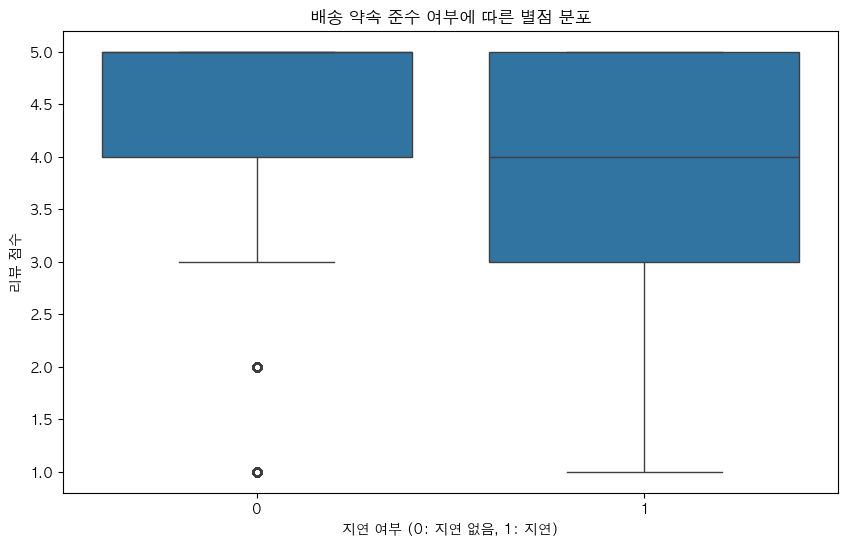

In [28]:
# 날짜 데이터 형식 변환
df['shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'])
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])

# 배송 약속 준수 여부 변수 생성 (is_late)
# 실제 물류센터에 넘긴 날짜가 기한보다 늦으면 1(지연), 아니면 0(지연 없음)
df['is_late'] = (df['order_delivered_carrier_date'] > df['shipping_limit_date']).astype(int)

# 지연 여부에 따른 평균 리뷰 점수 비교
late_review_stats = df.groupby('is_late')['review_score'].agg(['mean', 'count', 'std']).reset_index()
late_review_stats.columns = ['지연여부(0:지연 없음, 1:지연)', '평균별점', '주문건수', '표준편차']

print("--- 배송 기한 지연 여부별 별점 차이 ---")
display(late_review_stats)

# 시각화 
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_late', y='review_score', data=df)
plt.title('배송 약속 준수 여부에 따른 별점 분포')
plt.xlabel('지연 여부 (0: 지연 없음, 1: 지연)')
plt.ylabel('리뷰 점수')
plt.show()

In [29]:
# 통계적 유의성 검정 (T-test)
late_0 = df[df['is_late'] == 0]['review_score']
late_1 = df[df['is_late'] == 1]['review_score']
t_stat, p_val = stats.ttest_ind(late_0, late_1)
print(f"\nT-test 결과: p-value는 {p_val:.4f}")
if p_val < 0.05:
    print("=> 결론: 배송 약속 준수 여부는 고객 만족도에 통계적으로 '매우 유의미한' 차이를 만듦")

print()

# 두 그룹의 평균 별점
print(f" 배송 지연 없음 - 평균 별점: {late_0.mean():.2f}점")
print(f" 배송 지연 있음 - 평균 별점: {late_1.mean():.2f}점")

# 두 점수의 차이가 0.5점 이상 난다면, p-value 0은 아주 정상적인 결과


T-test 결과: p-value는 0.0000
=> 결론: 배송 약속 준수 여부는 고객 만족도에 통계적으로 '매우 유의미한' 차이를 만듦

 배송 지연 없음 - 평균 별점: 4.22점
 배송 지연 있음 - 평균 별점: 3.76점


## 결제 수단별 예민도 분석 
- 결제 수단별 별점이 다른지, 지연 되었을 때 별점이 깎이는 결제 수단 있는지 

In [30]:
# 결제 수단별 기초 통계 확인
payment_stats = df.groupby('payment_types')['review_score'].agg(['mean', 'count']).reset_index()
payment_stats.columns = ['결제수단', '평균별점', '주문건수']
payment_stats = payment_stats.sort_values(by='평균별점', ascending=False)

print("--- 결제 수단별 평균 별점 ---")
display(payment_stats)

--- 결제 수단별 평균 별점 ---


,결제수단,평균별점,주문건수
3,debit_card,4.303867,1267
5,"voucher,credit_card",4.211391,913
1,credit_card,4.188200,62354
4,voucher,4.162162,1073
0,boleto,4.153834,19274
2,"credit_card,voucher",4.128927,923


In [31]:
# 결제 수단별 '지연'에 대한 예민도 확인
sensitivity = df.pivot_table(index='payment_types', 
                             columns='is_late', 
                             values='review_score', 
                             aggfunc='mean')
sensitivity['차이(예민도)'] = sensitivity[0] - sensitivity[1]

print("\n--- 결제 수단별 지연 시 별점 하락폭 (예민도) ---")
display(sensitivity.sort_values(by='차이(예민도)', ascending=False))


--- 결제 수단별 지연 시 별점 하락폭 (예민도) ---


is_late,0,1,차이(예민도)
payment_types,,,
voucher,4.201403,3.640000,0.561403
boleto,4.208878,3.670892,0.537985
"credit_card,voucher",4.178657,3.662921,0.515736
credit_card,4.226695,3.784068,0.442628
"voucher,credit_card",4.237470,3.920000,0.317470
debit_card,4.327739,4.103704,0.224035


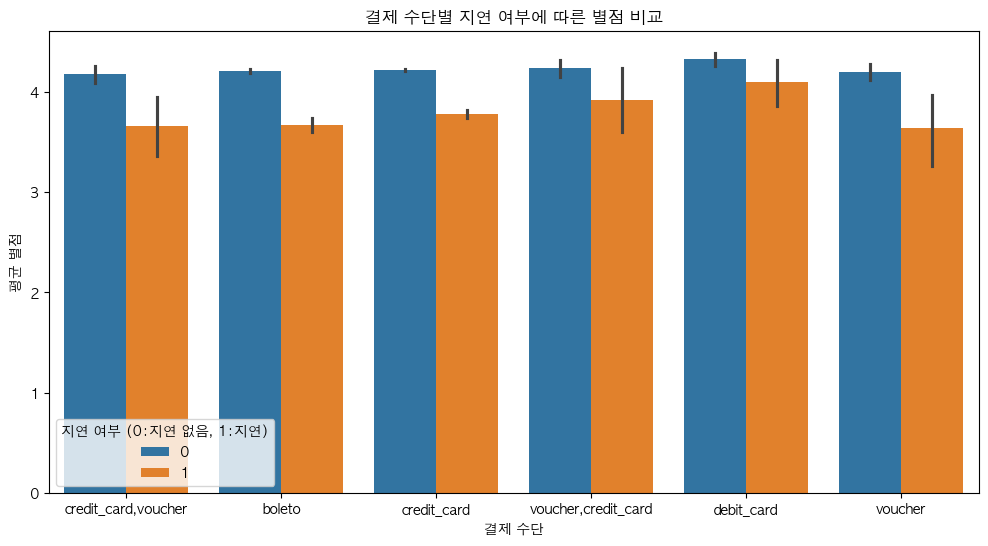

In [32]:
# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='payment_types', y='review_score', hue='is_late', data=df)
plt.title('결제 수단별 지연 여부에 따른 별점 비교')
plt.xlabel('결제 수단')
plt.ylabel('평균 별점')
plt.legend(title='지연 여부 (0:지연 없음, 1:지연)')
plt.show()

In [33]:
# ANOVA 모델 설정 (별점 ~ 결제수단 + 지연여부 + 결제수단:지연여부)
# C()는 범주형 변수임 표시 
model = ols('review_score ~ C(payment_types) * C(is_late)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("--- 이원 분산 분석 결과 ---")
display(anova_table)

# 결과 해석 
p_interaction = anova_table.loc['C(payment_types):C(is_late)', 'PR(>F)']

print(f"\n상호작용 효과의 p-value: {p_interaction:.4f}")

if p_interaction < 0.05:
    print("=> 결론: 결제 수단별 예민도 차이는 통계적으로 유의미함 (= 우연이 아님)")
    print("   즉, 어떤 결제 수단을 썼느냐에 따라 지연 시 별점이 깎이는 정도가 다르다.")
else:
    print("=> 결론: 결제 수단별 차이가 있지만, 통계적으로는 우연일 가능성이 있음.")

--- 이원 분산 분석 결과 ---


,sum_sq,df,F,PR(>F)
C(payment_types),36.241083,5.0,4.606685,3.330294e-04
C(is_late),1517.538350,1.0,964.488424,1.394045e-210
C(payment_types):C(is_late),21.250918,5.0,2.701252,1.907579e-02
Residual,134986.223682,85792.0,NaN,NaN



상호작용 효과의 p-value: 0.0191
=> 결론: 결제 수단별 예민도 차이는 통계적으로 유의미함 (= 우연이 아님)
   즉, 어떤 결제 수단을 썼느냐에 따라 지연 시 별점이 깎이는 정도가 다르다.


## 카테고리별 지연 허용치 분석 
- 어떤 물건은 n일 늦어도 괜찮지만, 어떤 물건은 하루만 늦어도 별점이 깎이는지 

In [34]:
# 카테고리별로 '지연'되었을 때 별점이 얼마나 깎이는지 계산
cat_sensitivity = df.pivot_table(index='product_category_name_english', 
                                 columns='is_late', 
                                 values='review_score', 
                                 aggfunc=['mean', 'count'])

# 컬럼 이름 정리
cat_sensitivity.columns = ['지연없음_평균', '지연_평균', '지연없음_건수', '지연_건수']

# 지연 시 별점이 가장 많이 깎이는 카테고리(예민한 카테고리) 순위 매기기
# (주문 건수가 어느 정도 있는 카테고리만 필터링 - 최소 100건 이상)
cat_sensitivity = cat_sensitivity[cat_sensitivity['지연없음_건수'] + cat_sensitivity['지연_건수'] >= 100]
cat_sensitivity['별점_하락폭'] = cat_sensitivity['지연없음_평균'] - cat_sensitivity['지연_평균']

print("--- 지연에 예민한 카테고리 상위 10 ---")
display(cat_sensitivity.sort_values(by='별점_하락폭', ascending=False).head(10))

--- 지연에 예민한 카테고리 상위 10 ---


,지연없음_평균,지연_평균,지연없음_건수,지연_건수,별점_하락폭
product_category_name_english,,,,,
signaling_and_security,4.194444,2.666667,144.0,6.0,1.527778
fashion_underwear_beach,4.437500,3.350000,80.0,20.0,1.087500
fixed_telephony,3.932584,3.000000,178.0,17.0,0.932584
computers,4.429825,3.545455,114.0,11.0,0.884370
costruction_tools_garden,4.211180,3.333333,161.0,21.0,0.877847
construction_tools_construction,4.241018,3.425532,668.0,47.0,0.815486
drinks,4.200787,3.407407,254.0,27.0,0.793380
musical_instruments,4.359155,3.567568,426.0,37.0,0.791587
computers_accessories,4.138874,3.359195,5451.0,696.0,0.779678


## 최악의 불만족 조합 찾기 
- 지연이 발생했을때, 별점이 얼마나 깎이는지 

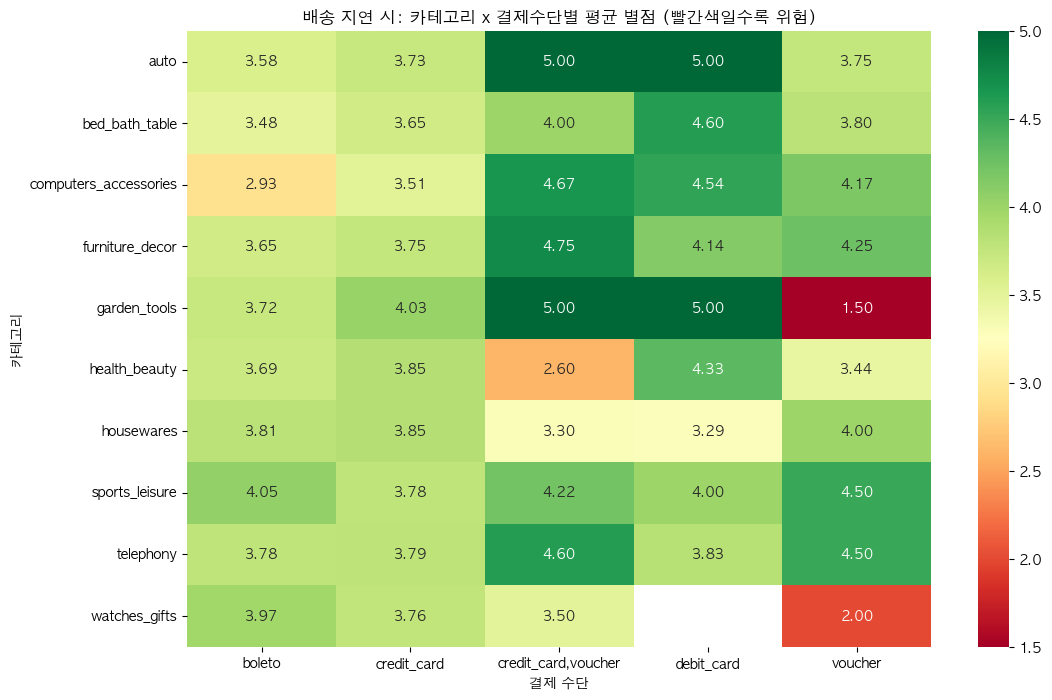

In [35]:
# 일부분 추출 -> 확인 

# 상위 카테고리 10개와 결제 수단 추출
top_categories = df['product_category_name_english'].value_counts().head(10).index
top_payments = df['payment_types'].value_counts().head(5).index

# 지연 발생 건만 추출
late_df = df[(df['is_late'] == 1) & 
            (df['product_category_name_english'].isin(top_categories)) &
            (df['payment_types'].isin(top_payments))]

# 카테고리 x 결제수단 별 평균 별점 계산 
pivot_table = late_df.pivot_table(index='product_category_name_english', 
                                  columns='payment_types', 
                                  values='review_score', 
                                  aggfunc='mean')

# 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title('배송 지연 시: 카테고리 x 결제수단별 평균 별점 (빨간색일수록 위험)')
plt.xlabel('결제 수단')
plt.ylabel('카테고리')
plt.show()

In [36]:
# 별점 하락폭 분포 (전체)

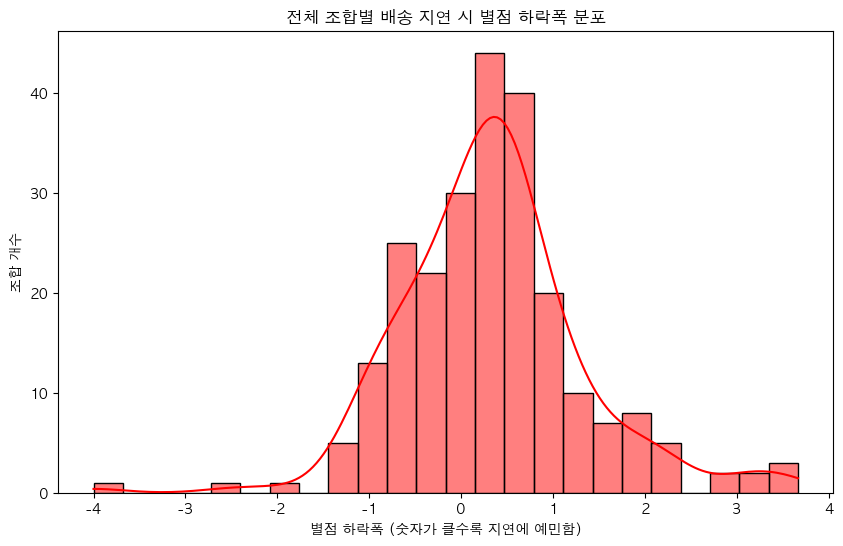

In [37]:
# 모든 카테고리 x 모든 결제수단에 대해 '지연 시 별점 하락폭' 계산
total_pivot = df.pivot_table(index='product_category_name_english', 
                             columns='payment_types', 
                             values='review_score', 
                             aggfunc=lambda x: x[df.loc[x.index, 'is_late'] == 0].mean() - x[df.loc[x.index, 'is_late'] == 1].mean())

# 시각화
plt.figure(figsize=(10, 6))
sns.histplot(total_pivot.values.flatten(), kde=True, color='red')
plt.title('전체 조합별 배송 지연 시 별점 하락폭 분포')
plt.xlabel('별점 하락폭 (숫자가 클수록 지연에 예민함)')
plt.ylabel('조합 개수')
plt.show()

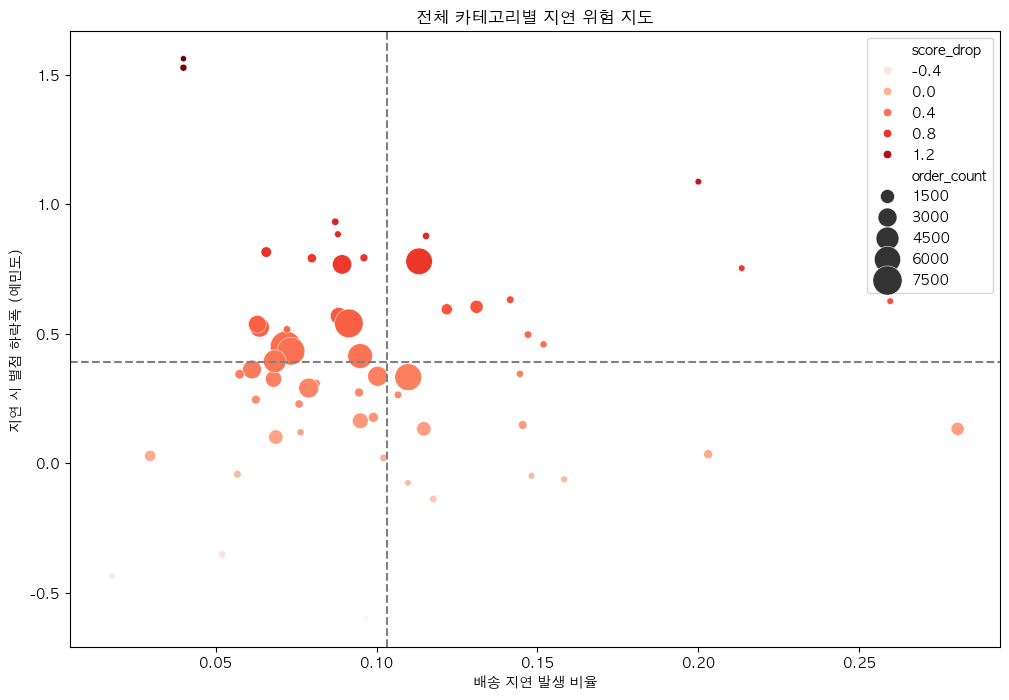

In [38]:
# 카테고리별 지연율과 하락폭 계산
cat_summary = df.groupby('product_category_name_english').agg(
    delay_rate=('is_late', 'mean'),
    score_drop=('review_score', lambda x: x[df.loc[x.index, 'is_late'] == 0].mean() - x[df.loc[x.index, 'is_late'] == 1].mean()),
    order_count=('order_id', 'count')
).dropna()

# 최소 주문 건수 50건 이상인 것만 표시
cat_summary = cat_summary[cat_summary['order_count'] >= 50]

plt.figure(figsize=(12, 8))
sns.scatterplot(data=cat_summary, x='delay_rate', y='score_drop', size='order_count', hue='score_drop', palette='Reds', sizes=(20, 500))

# 평균선 그리기 (위험 구역 구분)
plt.axvline(cat_summary['delay_rate'].mean(), color='gray', linestyle='--')
plt.axhline(cat_summary['score_drop'].mean(), color='gray', linestyle='--')

plt.title('전체 카테고리별 지연 위험 지도')
plt.xlabel('배송 지연 발생 비율')
plt.ylabel('지연 시 별점 하락폭 (예민도)')
plt.show()


In [39]:
# 1사분면 (오른쪽 상단) 카테고리 추출 _ 배송 늦음 + 늦으면 화내는 물건

In [40]:
# 기준점 계산 
avg_delay = cat_summary['delay_rate'].mean()
avg_drop = cat_summary['score_drop'].mean()

# 2사분면 필터링
# 조건: 지연율은 평균보다 낮고(잘함) AND 하락폭은 평균보다 높은(예민함)
quadrant_2 = cat_summary[
    (cat_summary['delay_rate'] < avg_delay) & 
    (cat_summary['score_drop'] > avg_drop)
].sort_values(by='score_drop', ascending=False)

print(f"--- 2사분면 예민보스 카테고리 (총 {len(quadrant_2)}개) ---")
print(f"기준: 지연율 {avg_delay:.2%} 미만 / 별점 하락폭 {avg_drop:.2f}점 초과")
display(quadrant_2[['order_count', 'delay_rate', 'score_drop']])

--- 2사분면 예민보스 카테고리 (총 17개) ---
기준: 지연율 10.32% 미만 / 별점 하락폭 0.39점 초과


,order_count,delay_rate,score_drop
product_category_name_english,,,
dvds_blu_ray,50,0.040000,1.562500
signaling_and_security,150,0.040000,1.527778
fixed_telephony,195,0.087179,0.932584
computers,125,0.088000,0.884370
construction_tools_construction,715,0.065734,0.815486
drinks,281,0.096085,0.793380
musical_instruments,463,0.079914,0.791587
toys,3136,0.089286,0.767787
baby,2278,0.088235,0.568930


In [41]:
# 2사분면 (왼쪽 상단) 카테고리 추출 _ 평소엔 배송을 잘 함 + 한번 늦으면 무섭게 

In [42]:
# 기준점 계산 (전체 카테고리의 평균값)
avg_delay = cat_summary['delay_rate'].mean()
avg_drop = cat_summary['score_drop'].mean()

# 2사분면 추출 (지연율 < 평균, 하락폭 > 평균)
quadrant_2 = cat_summary[
    (cat_summary['delay_rate'] < avg_delay) & 
    (cat_summary['score_drop'] > avg_drop)
].sort_values(by='score_drop', ascending=False)

print(f"--- [2사분면: 예민보스] 총 {len(quadrant_2)}개 카테고리 추출 ---")
print(f"기준: 지연율 {avg_delay:.2%} 미만 / 별점 하락폭 {avg_drop:.2f}점 초과")
display(quadrant_2[['order_count', 'delay_rate', 'score_drop']])

--- [2사분면: 예민보스] 총 17개 카테고리 추출 ---
기준: 지연율 10.32% 미만 / 별점 하락폭 0.39점 초과


,order_count,delay_rate,score_drop
product_category_name_english,,,
dvds_blu_ray,50,0.040000,1.562500
signaling_and_security,150,0.040000,1.527778
fixed_telephony,195,0.087179,0.932584
computers,125,0.088000,0.884370
construction_tools_construction,715,0.065734,0.815486
drinks,281,0.096085,0.793380
musical_instruments,463,0.079914,0.791587
toys,3136,0.089286,0.767787
baby,2278,0.088235,0.568930


In [43]:
# 4사분면 (오른쪽 하단) _ 배송 자주 늦음 + 고객이 늦는 것 이해해주는 물건 

In [44]:
# 기준점 계산
avg_delay = cat_summary['delay_rate'].mean()
avg_drop = cat_summary['score_drop'].mean()

# 4사분면 추출 (지연율 >= 평균, 하락폭 < 평균)
quadrant_4 = cat_summary[
    (cat_summary['delay_rate'] >= avg_delay) & 
    (cat_summary['score_drop'] < avg_drop)
].sort_values(by='delay_rate', ascending=False)

print(f"--- [4사분면: 만성지연/저예민] 총 {len(quadrant_4)}개 카테고리 추출 ---")
print(f"기준: 지연율 {avg_delay:.2%} 이상 / 별점 하락폭 {avg_drop:.2f}점 미만")
display(quadrant_4[['order_count', 'delay_rate', 'score_drop']])

--- [4사분면: 만성지연/저예민] 총 11개 카테고리 추출 ---
기준: 지연율 10.32% 이상 / 별점 하락폭 0.39점 미만


,order_count,delay_rate,score_drop
product_category_name_english,,,
office_furniture,1276,0.280564,0.132338
home_construction,458,0.203057,0.034320
construction_tools_safety,139,0.158273,-0.062549
christmas_supplies,108,0.148148,-0.048913
furniture_living_room,392,0.145408,0.147421
home_appliances_2,166,0.144578,0.345070
kitchen_dining_laundry_garden_furniture,204,0.117647,-0.138889
pet_shop,1578,0.114702,0.132549
furniture_decor,6300,0.109841,0.332315


In [45]:
# 3사분면 _ 지연 없음 + 지연 없어도 별점이 크게 안떨어짐 (=효자 카테고리)

In [46]:
# 기준점 계산
avg_delay = cat_summary['delay_rate'].mean()
avg_drop = cat_summary['score_drop'].mean()

# 3사분면 추출 (지연율 < 평균, 하락폭 < 평균)
quadrant_3 = cat_summary[
    (cat_summary['delay_rate'] < avg_delay) & 
    (cat_summary['score_drop'] < avg_drop)
].sort_values(by='order_count', ascending=False) # 주문이 많은 순서대로

print(f"--- [3사분면: 안전군] 총 {len(quadrant_3)}개 카테고리 추출 ---")
print(f"기준: 지연율 {avg_delay:.2%} 미만 / 별점 하락폭 {avg_drop:.2f}점 미만")
display(quadrant_3[['order_count', 'delay_rate', 'score_drop']])

--- [3사분면: 안전군] 총 19개 카테고리 추출 ---
기준: 지연율 10.32% 미만 / 별점 하락폭 0.39점 미만


,order_count,delay_rate,score_drop
product_category_name_english,,,
telephony,3328,0.100361,0.335547
garden_tools,3307,0.078923,0.290131
cool_stuff,2903,0.061316,0.361981
electronics,2162,0.067993,0.324991
stationery,1969,0.094972,0.163432
fashion_bags_accessories,1572,0.068702,0.100789
luggage_accessories,876,0.029680,0.027964
home_appliances,616,0.099026,0.176961
small_appliances,522,0.057471,0.343496


## 배송을 늦게 하면서 동시에 1~3점 별점을 많이 받는 판매자 추출하기 

In [47]:
# 1~3점을 '낮은 리뷰(low_review)'로 정의
df['is_low_review'] = (df['review_score'] <= 3).astype(int)

# 판매자별로 '지연 발생 시 1~3점 리뷰를 줄 확률'
seller_risk_analysis = df.groupby('seller_id').agg(
    total_orders=('order_id', 'count'),
    delay_rate=('is_late', 'mean'),  # 지연율
    low_review_ratio=('is_low_review', 'mean')  # 1~3점 리뷰 비율
).reset_index()

# 전체 평균과 비교하여 '유의 판매자' 후보군 추출
# 최소 10건 이상 판매자 중 지연율과 불만족 비율이 모두 평균 이상인 경우
avg_delay = seller_risk_analysis['delay_rate'].mean()
avg_low_rev = seller_risk_analysis['low_review_ratio'].mean()

final_target_sellers = seller_risk_analysis[
    (seller_risk_analysis['total_orders'] >= 10) & 
    (seller_risk_analysis['delay_rate'] > avg_delay) & 
    (seller_risk_analysis['low_review_ratio'] > avg_low_rev)
].sort_values(by='low_review_ratio', ascending=False)

print(f"--- 1~3점 기준 유의 관리 판매자 ---")
display(final_target_sellers.head(10))

--- 1~3점 기준 유의 관리 판매자 ---


,seller_id,total_orders,delay_rate,low_review_ratio
431,270d3ef21830ad0ecf3a6c53d08a533a,17,0.117647,0.941176
1036,5bc55dbe2f12b6af6d83ed46023e0dc8,17,0.117647,0.823529
1575,8bd0e3abda539b9479c4b44a691be1ec,13,0.307692,0.769231
1696,973f21788dfab357250f69a8dcb7ddee,14,0.857143,0.714286
307,1ca7077d890b907f89be8c954a02686a,100,0.450000,0.700000
53,054694fa03fe82cec4b7551487331d74,13,0.692308,0.615385
1593,8d899e15a5925f097cca50faa49b15e3,10,0.600000,0.600000
2747,f9903dd0f812c7e771fcad47b6fff231,12,0.416667,0.583333
1695,972d0f9cf61b499a4812cf0bfa3ad3c4,59,0.372881,0.576271
5,00720abe85ba0859807595bbf045a33b,16,0.125000,0.562500


## 월별 배송 지연율 & 월별 처리 지연율 
- 월 별 배송 지연율 : is_logistics_fault 가 estimated 보다 늦게 받은 경우 (시스템 배송 품질)
- 판매자 지연 : seller_delay_days > 0 : 판매자가 물건을 택배사에 늦게 준 경우
- 물류 과실 : is_logistics_fault = True : 고객이 늦게 받은 경우 

#### 월별 배송 지연율 

In [61]:
# 데이터 형식 변환 (order_approved_at)
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])

# 월(Year-Month) 컬럼 생성
df['order_month'] = df['order_approved_at'].dt.to_period('M')

# 지연 지표 계산
# 배송 지연율: is_logistics_fault 
# 처리 지연 비율: seller_delay_days > 0 
df['is_seller_delay'] = (df['seller_delay_days'] > 0).astype(int)

# 월별 배송 지연율 산출
monthly_logistics = df.groupby('order_month').agg(
    total_orders=('order_id', 'count'),
    logistics_fault_count=('is_logistics_fault', 'sum')
).reset_index()

monthly_logistics['logistics_delay_rate(%)'] = (monthly_logistics['logistics_fault_count'] / monthly_logistics['total_orders'] * 100).round(2)

print("--- 월별 배송 지연율 (전체 물류 과실) ---")
display(monthly_logistics[['order_month', 'total_orders', 'logistics_delay_rate(%)']])

--- 월별 배송 지연율 (전체 물류 과실) ---


,order_month,total_orders,logistics_delay_rate(%)
0,2017-01,713,0.70
1,2017-02,1630,1.41
2,2017-03,2586,2.28
3,2017-04,2037,3.83
4,2017-05,3338,2.04
5,2017-06,3030,1.85
6,2017-07,3623,1.44
7,2017-08,3964,1.39
8,2017-09,3982,2.69
9,2017-10,4351,2.74


#### 월별 처리 지연율 

In [55]:
# 월별 처리 지연율 
df['is_seller_delay'] = (df['seller_delay_days'] > 0).astype(int)

monthly_seller = df.groupby('order_month').agg(
    total_orders=('order_id', 'count'),
    seller_delay_count=('is_seller_delay', 'sum')
).reset_index()

monthly_seller['seller_delay_rate(%)'] = (monthly_seller['seller_delay_count'] / monthly_seller['total_orders'] * 100).round(2)

print("--- 월별 처리 지연율 (판매자 운영 과실) ---")
display(monthly_seller[['order_month', 'total_orders', 'seller_delay_rate(%)']])

--- 월별 처리 지연율 (판매자 운영 과실) ---


,order_month,total_orders,seller_delay_rate(%)
0,2017-01,713,22.02
1,2017-02,1630,16.13
2,2017-03,2586,7.19
3,2017-04,2037,7.07
4,2017-05,3338,6.98
5,2017-06,3030,7.62
6,2017-07,3623,8.86
7,2017-08,3964,6.58
8,2017-09,3982,7.31
9,2017-10,4351,7.40


In [57]:
# 판매자 처리 지연 여부 정의 (양수이면 지연)
df['is_seller_delay'] = (df['seller_delay_days'] > 0).astype(int)

# 월별 통합 집계
monthly_combined = df.groupby('order_month').agg(
    total_orders=('order_id', 'count'),
    logistics_fault_count=('is_logistics_fault', 'sum'),
    seller_delay_count=('is_seller_delay', 'sum')
).reset_index()

# 각 지연율(%) 계산
monthly_combined['배송_지연율(%)'] = (monthly_combined['logistics_fault_count'] / monthly_combined['total_orders'] * 100).round(2)
monthly_combined['처리_지연율(%)'] = (monthly_combined['seller_delay_count'] / monthly_combined['total_orders'] * 100).round(2)

# 컬럼 정리 + 출력
report = monthly_combined[['order_month', 'total_orders', '배송_지연율(%)', '처리_지연율(%)']]
report.columns = ['주문 월', '전체 주문수', '배송 지연율(전체)', '처리 지연율(판매자)']

print("--- 월별 배송 및 처리 지연 현황 ---")
display(report.sort_values('주문 월'))

--- 월별 배송 및 처리 지연 현황 ---


,주문 월,전체 주문수,배송 지연율(전체),처리 지연율(판매자)
0,2017-01,713,0.70,22.02
1,2017-02,1630,1.41,16.13
2,2017-03,2586,2.28,7.19
3,2017-04,2037,3.83,7.07
4,2017-05,3338,2.04,6.98
5,2017-06,3030,1.85,7.62
6,2017-07,3623,1.44,8.86
7,2017-08,3964,1.39,6.58
8,2017-09,3982,2.69,7.31
9,2017-10,4351,2.74,7.40


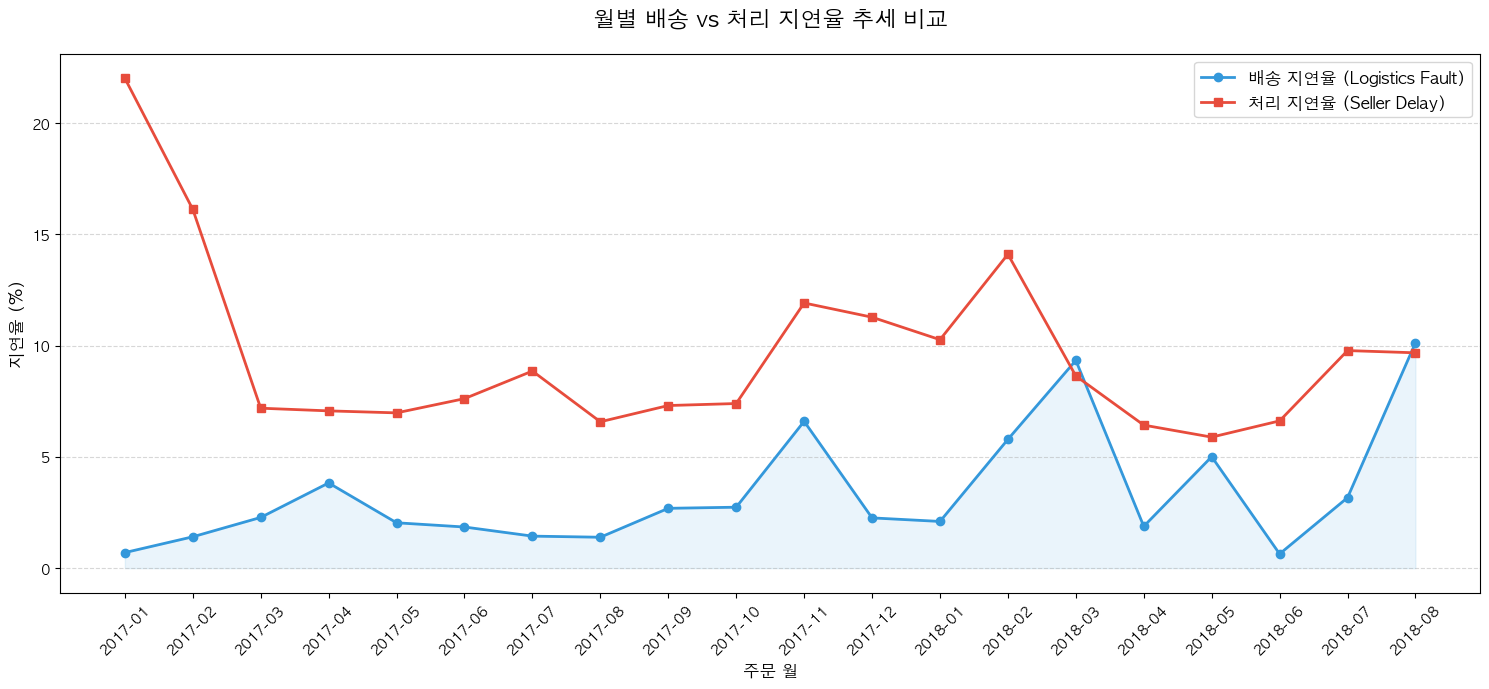

In [59]:
# 시각화 
plt.figure(figsize=(15, 7))

# 배송 지연율 (전체) - 파란색
plt.plot(report_df['주문 월'], report_df['배송 지연율(전체)'], 
         label='배송 지연율 (Logistics Fault)', marker='o', linewidth=2, color='#3498db')

# 처리 지연율 (판매자) - 빨간색
plt.plot(report_df['주문 월'], report_df['처리 지연율(판매자)'], 
         label='처리 지연율 (Seller Delay)', marker='s', linewidth=2, color='#e74c3c')

# 시각화 
plt.fill_between(report_df['주문 월'], report_df['배송 지연율(전체)'], color='#3498db', alpha=0.1)
plt.title('월별 배송 vs 처리 지연율 추세 비교', fontsize=16, pad=20)
plt.xlabel('주문 월', fontsize=12)
plt.ylabel('지연율 (%)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [60]:
# 같이 솟구치면 = 동반 상승 구간 (판매자가 늦게 보내서 고객이 늦게 받음) = 판매자 책임
# 간격 벌어짐 (갭) = 배송 높고 처리 낮음 = 판매자는 지연 없음 잘 지킴, 택배사가 늦게 배달 (배송 인프라) 
# 빨간선이 더 높음 = 판매자가 늦었는데도 택배사가 초스피트 배송 -> 고객 정상 배달 (잠재적 위험군)